# Task 2: Ensemble classifiers
For this assignment we will employing predictive models based on decision trees to examine a dataset of cancer patients with the presence of 101 different peptides in the patients' organisms. The data is found in the files `cancerData.csv` and `cancerInfo.csv`.

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score, zero_one_loss
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

## 1. Exploratory Data Analysis

We first import the data and analyse is structure. We can immediately see that the data ingestion pipeline will require some work.

In [2]:
df1 = pd.read_csv("cancerDat.csv", sep = ";", decimal = ",")
df1 = df1.T
df1 = df1.drop('Unnamed: 0', axis=0)
display(df1.head())
print(df1.shape)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
NO.REC_1,21.923472,24.442617,19.050562,18.482667,24.086793,20.32946,19.304363,24.270429,18.878984,18.752264,...,19.439382,16.142102,22.858297,22.262118,18.079186,17.151515,20.912124,17.298159,19.097263,21.21211
NO.REC_2,21.020165,23.649841,18.402413,19.088996,24.710323,21.495392,19.454826,25.807051,19.091796,19.213397,...,20.631064,NaN,22.028998,22.031468,17.101384,18.315637,21.512601,17.100711,18.875548,23.980238
NO.REC_3,19.585788,23.736128,18.191527,16.33124,21.917326,20.284533,16.853825,22.661125,18.215654,20.821777,...,19.123832,16.171227,23.143305,22.334392,17.159968,16.859732,19.076147,15.417028,16.340283,19.810886
NO.REC_4,19.061767,23.374865,17.692775,15.36272,21.484924,18.379603,16.513507,21.401436,18.38696,19.847221,...,17.958307,NaN,19.183961,17.851328,16.564709,15.161135,18.190653,15.269443,15.411408,18.351433
NO.REC_5,18.547029,23.039588,19.066973,15.835721,21.339587,19.550809,16.831653,21.776832,17.85408,20.368534,...,18.212854,NaN,22.228449,21.385404,17.072001,15.071656,18.896095,15.147357,NaN,20.28779


(129, 102)


In [3]:
df2 = pd.read_csv("cancerInfo.csv", sep = ";")
df2 = df2.drop(['Unnamed: 0', 'Group'], axis = 1)
df2.index = df2.iloc[:,0]
df2 = df2.drop(['sampleNames'], axis = 1)

display(df2.head())

,sites
sampleNames,
NO.REC_1,A
NO.REC_2,B
NO.REC_3,C
NO.REC_4,C
NO.REC_5,C


We want to define a single response variable according to whether the cancer sees a recurrence or not. This is currently coded into the key of the patient, so we will create a separate binary vector to encode this response, where `0` will denote non-recurrence and `1` will denote recurrence.

In [4]:
indices1 = np.array(df1.index).astype(str)
index_array1 = np.zeros(len(indices1))
labels_1 = np.where(np.char.startswith(indices1, 'NO.REC_'), 0, np.where(np.char.startswith(indices1, 'REC_'), 1, index_array1))

indices2 = np.array(df2.index).astype(str)
index_array2 = np.zeros(len(indices2))
labels_2 = np.where(np.char.startswith(indices2, 'NO.REC_'), 0, np.where(np.char.startswith(indices2, 'REC_'), 1, index_array2))

print("Labels are equal: " + str(np.array_equal(labels_1, labels_2))) # That is we can define a single response variable y for the two files
y = labels_1

Labels are equal: True


In [5]:
y = pd.Series(y)
display(y)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
124    1.0
125    1.0
126    1.0
127    1.0
128    1.0
Length: 129, dtype: float64

Now we will check for missing values and some descriptive statistics of the data. There is a substantial amount of missing values in the dataset, so in order to avoid discarding such a large amount of information, we resort to imputing the linear iterpolation of the missing entries. This increases the amount of information that we work with but we claim that for the final results this is prefereable to eliminating the entire rows and rendering our dataset almost empty.

In [6]:
for col in df1:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
df1.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
97     float64
98     float64
99     float64
100    float64
101    float64
Length: 102, dtype: object

In [7]:
print(df1.isnull().values.any())
print(sum(df1.isnull()))
df1 = df1.interpolate(method ='linear', limit_direction ='forward')
print(df1.isnull().values.any())

True
5151
False


In [8]:
print(df2.isnull().values.any()) # False -> No nulls

False


Now that we have handled the missing values, we can go ahead and perform some more sophisticated exploration techniques.

In [9]:
df1.describe()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,19.930039,23.286214,18.226328,17.331228,22.591467,20.193446,18.133973,23.193300,18.687522,19.516615,...,19.126770,15.832452,21.643638,21.312564,17.060424,17.096818,19.891371,16.372295,17.653626,20.692479
std,1.646143,0.784218,1.126192,1.477403,1.562914,1.185180,1.751196,1.860021,1.744740,1.068425,...,1.399915,1.005218,1.009982,1.126496,0.881310,1.241427,1.487108,1.011885,1.123423,2.025807
min,15.836862,21.313713,14.401524,12.976690,18.807566,16.963778,13.770822,18.824646,16.818849,16.952402,...,14.488970,12.398937,18.802740,17.851328,15.050081,13.746502,15.860695,13.846473,14.930870,15.644922
25%,18.547029,22.755110,17.440432,16.166380,21.321595,19.397560,17.001766,22.036426,18.109188,18.830477,...,18.323381,15.358616,20.940953,20.538005,16.466670,16.297205,18.855134,15.707511,17.008565,19.477624
50%,20.341514,23.374865,18.349787,17.373647,22.461809,20.264099,18.421874,23.469361,18.548956,19.546749,...,19.240883,16.099669,21.663512,21.281094,17.156167,17.270199,19.892329,16.416639,17.691291,20.655011
75%,21.362745,23.793517,18.968572,18.501081,23.992847,20.961033,19.426085,24.633681,18.967436,20.108405,...,19.956155,16.514396,22.295952,22.004275,17.734682,18.003294,21.065003,17.101205,18.540819,22.009082
max,22.315946,25.387870,21.837865,19.994349,25.306821,23.671558,21.934433,26.596796,36.306672,22.920624,...,23.668357,19.057885,24.195671,23.932574,19.008904,20.339064,22.552429,18.586913,19.888654,25.794838


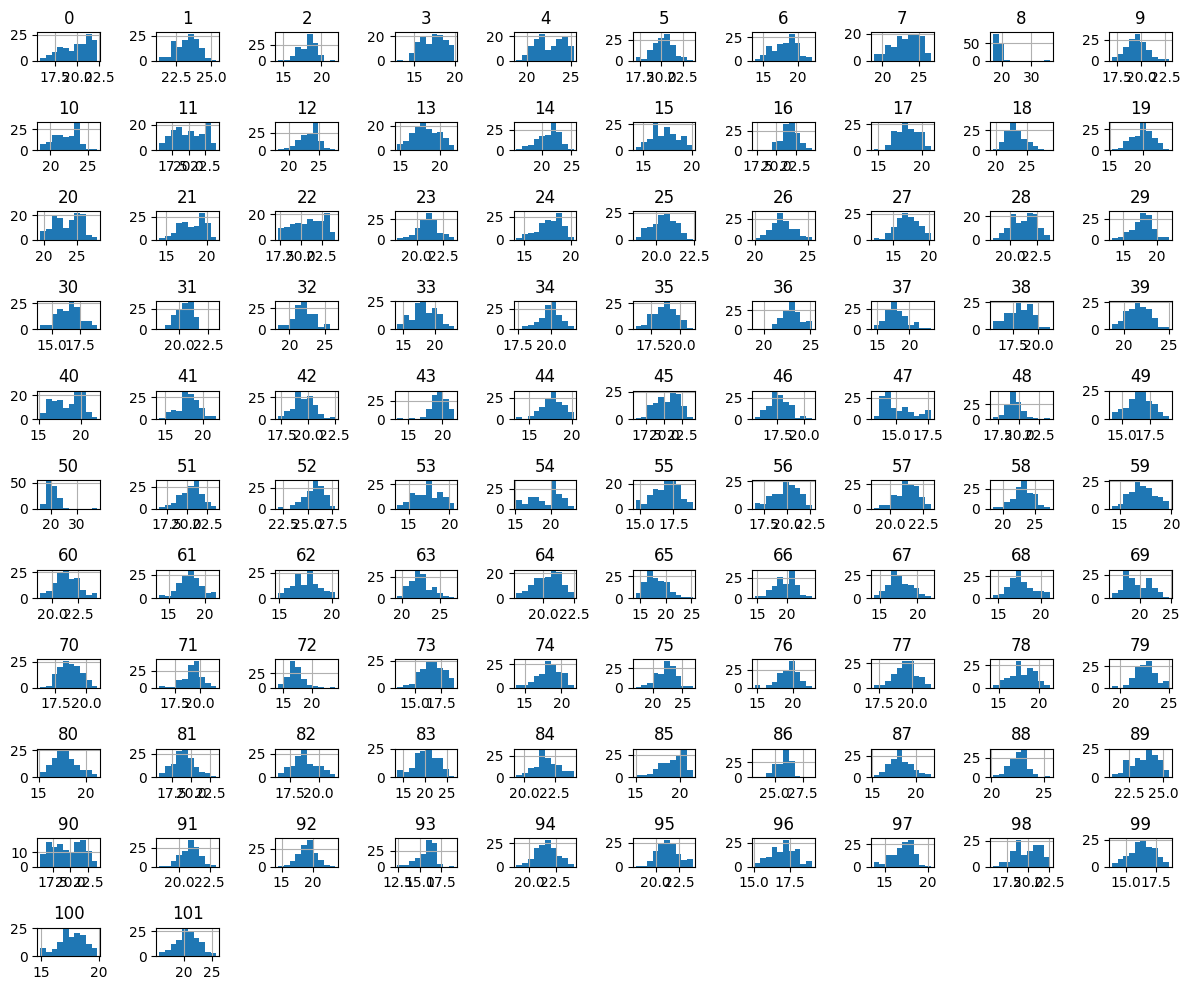

In [36]:
df1.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

In the previous cells, we can observe some erratic distributions for some of the covariates, where they do not seem to fit very well with the statement of the law of large numbers. Specifically, as an example, the covariates indexed in positions `15`, `54` or `78` have some interesting shapes.

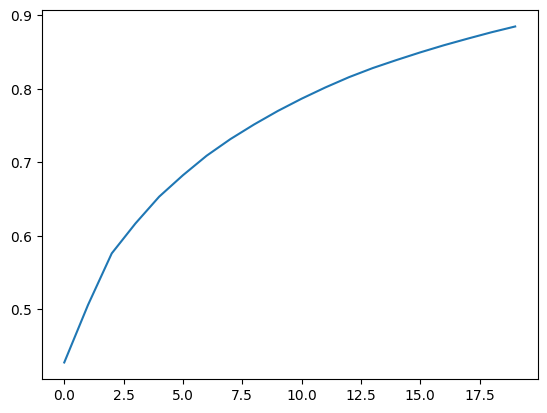

In [10]:
from sklearn.decomposition import PCA
import itertools
pca = PCA(n_components=20)
pca.fit_transform(df1)
#print(pca.explained_variance_ratio_)
#print(list(itertools.accumulate(pca.explained_variance_ratio_)))
plt.plot(list(itertools.accumulate(pca.explained_variance_ratio_)))

We can see from the PCA that the amount of variance accumulated by the twenty first principal components amounts to almost 90\%. Our final classifiers will only include ten peptides as features to train on.

## 2.Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split
np.random.seed(1234)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df1,
                                        y,
                                        test_size = 1/3,
                                        random_state = 1234)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(86, 102) (43, 102) (86,) (43,)


## 3. Model fitting

### 3.1. Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 1234)
parameters = {'n_estimators' : range(10,130,20),
              'max_features' : (1,2,3,4,5,6,7,8,9,10)
             }

In [44]:
grid_rf = GridSearchCV(rf, parameters)
grid_rf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=1234),
             param_grid={'max_features': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'n_estimators': range(10, 130, 20)})

In [45]:
rf_results = pd.DataFrame(grid_rf.cv_results_)
rf_results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_features,param_n_estimators,mean_test_score,std_test_score
36,7,10,0.594118,0.118234
55,10,30,0.582353,0.079792
48,9,10,0.572549,0.142693
1,1,30,0.569935,0.044213


In [51]:
best_params = grid_rf.best_params_
print("Best Parameters:", best_params)
best_rf = RandomForestClassifier(**best_params, random_state=1234)
best_rf.fit(X_train, y_train)

Best Parameters: {'max_features': 7, 'n_estimators': 10}


RandomForestClassifier(max_features=7, n_estimators=10, random_state=1234)

In [52]:
y_pred = best_rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.6511627906976745

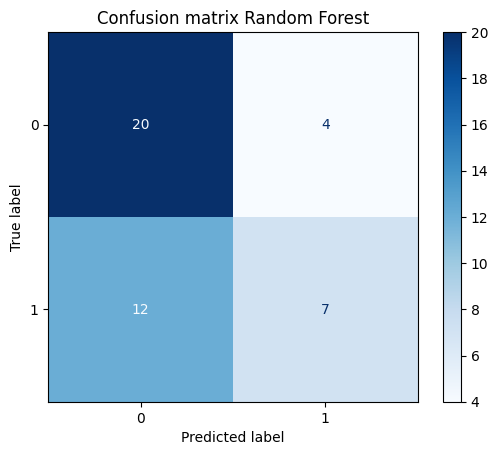

In [74]:
y_pred = best_gb.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_mtx, display_labels= None)
disp.plot(cmap= plt.cm.Blues)
plt.title("Confusion matrix Random Forest")
plt.show()

In [58]:
feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : feature_importances})
print(importance_df.sort_values(by=['Importance'], ascending=False).head(10))

    Feature  Importance
51       51    0.057151
11       11    0.043937
25       25    0.032852
96       96    0.030232
78       78    0.029687
76       76    0.028671
5         5    0.027653
34       34    0.026475
12       12    0.026456
62       62    0.024448


### 3.2. Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=2000, random_state=1234)
parameters = {'max_depth' : (1,4,8,16)}

In [61]:
grid_gb = GridSearchCV(gb, parameters)
grid_gb.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(n_estimators=2000,
                                                  random_state=1234),
             param_grid={'max_depth': (1, 4, 8, 16)})

In [62]:
gb_results = pd.DataFrame(grid_gb.cv_results_)
gb_results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,mean_test_score,std_test_score
0,1,0.524183,0.069834
2,8,0.454248,0.089378
3,16,0.454248,0.089378
1,4,0.442484,0.063287


Best Parameters: {'max_depth': 1}


Text(0, 0.5, 'Misclassification rate')

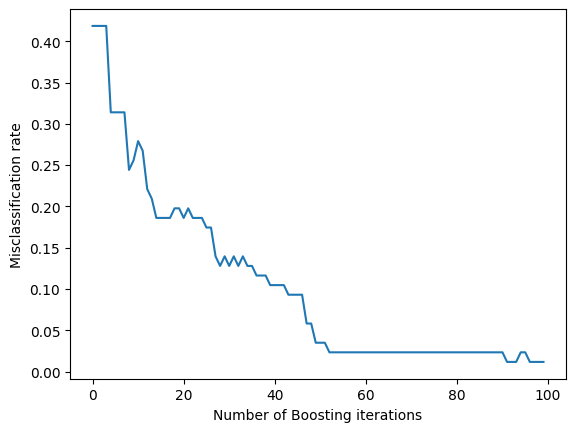

In [71]:
best_params = grid_gb.best_params_
print("Best Parameters:", best_params)

train_errors = []
best_gb = GradientBoostingClassifier(**best_params, random_state=1234)
best_gb.fit(X_train, y_train)

for i, y_pred_train in enumerate(best_gb.staged_predict(X_train)):
    train_errors.append(zero_one_loss(y_train, y_pred_train))

plt.plot(np.arange(0,100), train_errors)
plt.xlabel('Number of Boosting iterations')
plt.ylabel('Misclassification rate')
plt.title('Gradient Boosting Error Evolution')

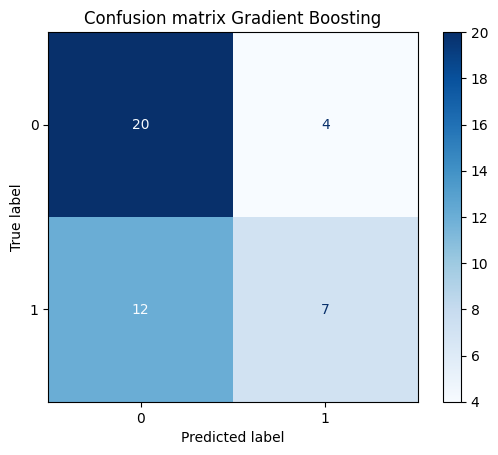

In [73]:
y_pred = best_gb.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_mtx, display_labels= None)
disp.plot(cmap= plt.cm.Blues)
plt.title("Confusion matrix Gradient Boosting")
plt.show()

### 3.3. XGBoost

In [81]:
import xgboost
xgb = xgboost.XGBClassifier(n_estimators=2000, random_state=1234)
parameters = {'max_depth' : (1,4,8,16),
             'learning_rate' : [0,2]
             }

In [82]:
grid_xgb = GridSearchCV(xgb, parameters)
grid_xgb.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=2000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=1234, ...),
             param_grid={'learning_rate': [0, 2], 'max_depth': (1, 4, 8, 16)})

In [83]:
xgb_results = pd.DataFrame(grid_xgb.cv_results_)
xgb_results.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,mean_test_score,std_test_score
0,0,1,0.581699,0.013072
1,0,4,0.581699,0.013072
2,0,8,0.581699,0.013072
3,0,16,0.581699,0.013072


In [85]:
best_params = grid_xgb.best_params_
print("Best Parameters:", best_params)

best_xgb = xgboost.XGBClassifier(**best_params, random_state=1234)
best_xgb.fit(X_train, y_train)

Best Parameters: {'learning_rate': 0, 'max_depth': 1}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1234, ...)

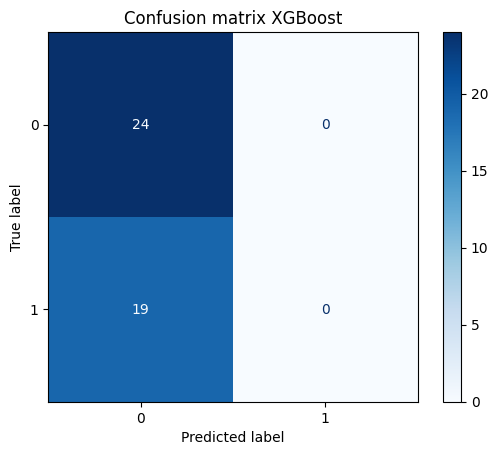

In [86]:
y_pred = best_xgb.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_mtx, display_labels= None)
disp.plot(cmap= plt.cm.Blues)
plt.title("Confusion matrix XGBoost")
plt.show()

We can see how the gradient boosting always predicts the most common class, and so has a large amount of Type 1 errors.

## 4. Predictor comparison